<a href="https://colab.research.google.com/github/plthiyagu/AI-Engineering/blob/master/06-Data%20Preprocessing/Feature_Transformation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


https://github.com/AsyaEvloeva/Feature-Transformation/blob/main/feature_transformation_cheatsheet.ipynb



In [ ]:
!pip install pyproj
!pip install google_trans_new

In [7]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import  stats
from collections import ChainMap
from datetime import datetime
from sklearn.cluster import KMeans
from pyproj import Proj, Transformer
from google_trans_new import google_translator  
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(20,5)})


In [8]:
df = pd.read_csv('https://raw.githubusercontent.com/plthiyagu/Personnel/master/Dataset/GlobalLandTemperatures_GlobalLandTemperaturesByMajorCity.csv')

In [9]:
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [10]:
df.duplicated().any()

False

In [11]:
# check overall stats on your dataset
def show_stats(df):
    print(df.describe())
    for column in list(df.columns):
        print(column, '| Data type: ', df[column].dtype, '| Null values: ', df[column].isnull().sum(), round(df[column].isnull().sum()/len(df)*100, 2), '%', '| Numer of unique values: ',  len(np.unique(list(df[column].astype(str)))))
        print()

In [12]:
show_stats(df)

       AverageTemperature  AverageTemperatureUncertainty
count       228175.000000                  228175.000000
mean            18.125969                       0.969343
std             10.024800                       0.979644
min            -26.772000                       0.040000
25%             12.710000                       0.340000
50%             20.428000                       0.592000
75%             25.918000                       1.320000
max             38.283000                      14.037000
dt | Data type:  object | Null values:  0 0.0 % | Numer of unique values:  3239

AverageTemperature | Data type:  float64 | Null values:  11002 4.6 % | Numer of unique values:  56349

AverageTemperatureUncertainty | Data type:  float64 | Null values:  11002 4.6 % | Numer of unique values:  6270

City | Data type:  object | Null values:  0 0.0 % | Numer of unique values:  100

Country | Data type:  object | Null values:  0 0.0 % | Numer of unique values:  49

Latitude | Data type:  o

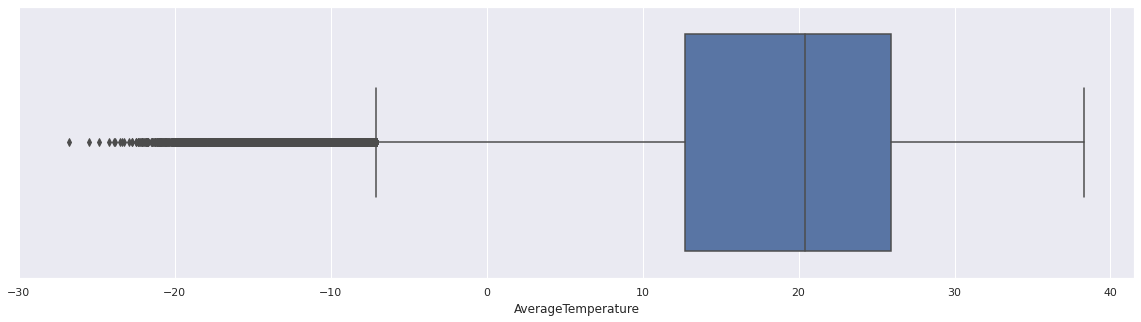

In [13]:
df['date'] = pd.to_datetime(df['dt'])
ax = sns.boxplot(x=df.index, data=df['AverageTemperature'])

In [14]:
# with mean
#df['AverageTemperature'] = df['AverageTemperature'].fillna(df['AverageTemperature'].mean())

# with median
df['AverageTemperature'] = df['AverageTemperature'].fillna(df['AverageTemperature'].median())

# with most frequent (mode)
#df['AverageTemperature'] = df['AverageTemperature'].fillna(df['AverageTemperature'].value_counts().index[0])

# with zero
#df['AverageTemperature'] = df['AverageTemperature'].fillna(0)

# with any value that much different from existed temperatures 
#df['AverageTemperature'] = df['AverageTemperature'].fillna(500)

# with predicted values
# XGBoost or similar models can be used to predict null values.

# do nothing or drop records with nulls
# Sometimes missing values are not applicable and imputing them is meaningless.

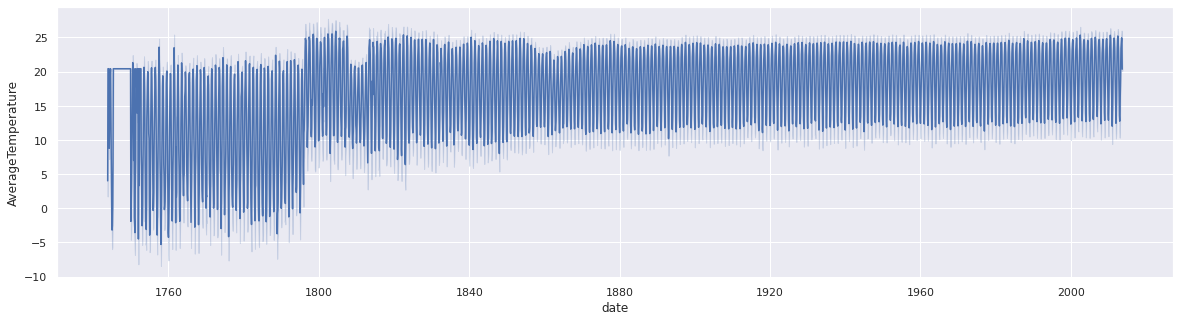

In [15]:
sns.lineplot(x=df['date'], y=df["AverageTemperature"])

In [16]:
# floats to int
df['AverageTemperature_int'] = df['AverageTemperature'].astype(int)

# round numbers
df['AverageTemperature_rounded'] = df['AverageTemperature'].round(1)

# scale with MinMaxScaler
scaler = MinMaxScaler()
df['AverageTemperature_minmax'] = scaler.fit_transform(df[['AverageTemperature']])

# scale with StandardScaler
scaler = StandardScaler()
df['AverageTemperature_standard'] = scaler.fit_transform(df[['AverageTemperature']])

# kmeans **
kmeans = KMeans(n_clusters=10, random_state=0).fit(df[['AverageTemperature']])
df['AverageTemperature_kmeans'] = kmeans.labels_

# kbins **
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
est.fit(df[['AverageTemperature']])
df['AverageTemperature_kbins'] = est.transform(df[['AverageTemperature']])

# log transformation
max_negative = abs(min(df['AverageTemperature']))
df['AverageTemperature_log'] = df['AverageTemperature'].apply(lambda x: x + max_negative + 0.001).replace(0, 0.001)
df["AverageTemperature_log"] = np.log(df['AverageTemperature_log'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


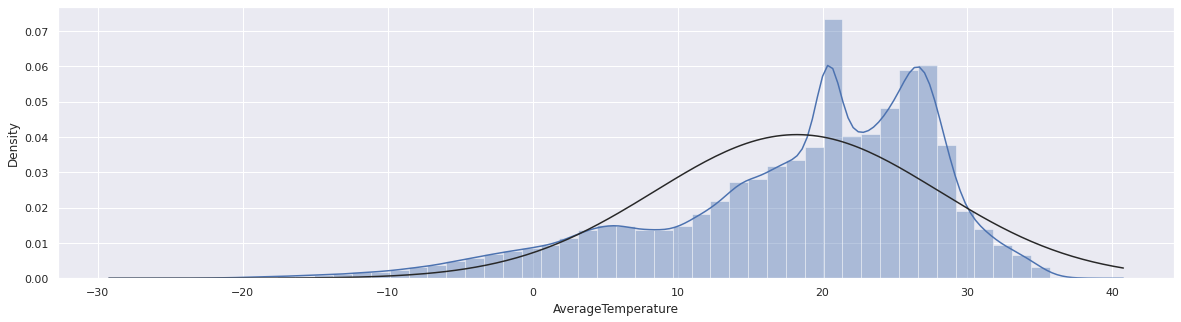

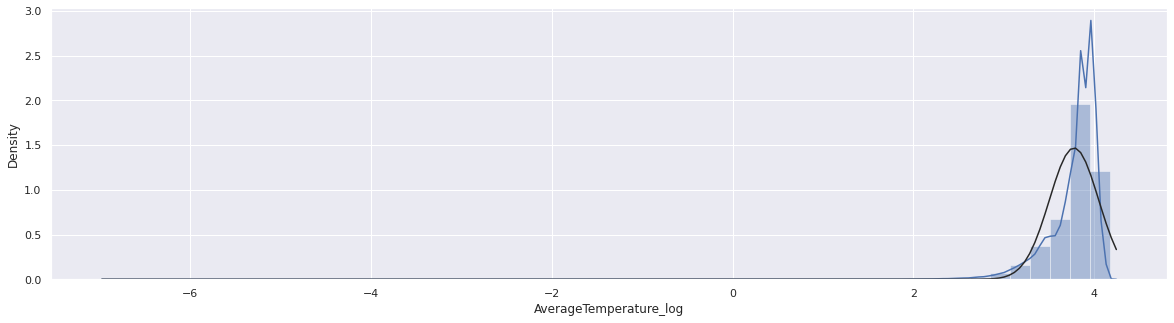

<Figure size 1440x360 with 0 Axes>

In [17]:
sns.distplot(df["AverageTemperature"], fit=stats.norm)
fig = plt.figure()
sns.distplot(df["AverageTemperature_log"], fit=stats.norm)
fig = plt.figure()

In [18]:
# onehotencoder (get dummies)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(df[['AverageTemperature_kbins']])
col_names = ['AverageTemperature_' + str(i) for i in range(len(np.unique(df['AverageTemperature_kbins'])))]
df[col_names] = enc.transform(df[['AverageTemperature_kbins']]).toarray()

# binary
df['AverageTemperature_hot_cold'] = df['AverageTemperature'].apply(lambda x: 'hot' if x > 10 else 'cold')

In [19]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,date,AverageTemperature_int,AverageTemperature_rounded,AverageTemperature_minmax,AverageTemperature_standard,AverageTemperature_kmeans,AverageTemperature_kbins,AverageTemperature_log,AverageTemperature_0,AverageTemperature_1,AverageTemperature_2,AverageTemperature_3,AverageTemperature_4,AverageTemperature_5,AverageTemperature_6,AverageTemperature_7,AverageTemperature_8,AverageTemperature_9,AverageTemperature_hot_cold
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-01-01,26,26.7,0.822012,0.864207,8,8.0,3.979252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-02-01,27,27.4,0.833233,0.938672,8,8.0,3.992810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-03-01,28,28.1,0.843486,1.006709,8,8.0,4.005040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-04-01,26,26.1,0.813343,0.806676,8,8.0,3.968649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-05-01,25,25.4,0.802383,0.733946,1,8.0,3.955082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E,2013-05-01,18,19.0,0.703266,0.076213,3,7.0,3.823236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E,2013-06-01,23,23.5,0.773100,0.539625,1,7.0,3.917906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E,2013-07-01,25,25.3,0.799677,0.715993,1,7.0,3.951705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E,2013-08-01,24,24.5,0.788564,0.642243,1,7.0,3.937710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot


In [20]:
# number of month in a year
df['month_of_year'] = df['date'].dt.month

# number of week in the year
df['week_of_year'] = df['date'].dt.week

# number of the day in the week ***
df['day_of_year'] = df['date'].dt.dayofyear

# season ***
def get_season(date):
    year = str(date.year)
    seasons = {'spring': pd.date_range(start='01/03/'+year, end='31/05/'+year),
               'summer': pd.date_range(start='01/06/'+year, end='31/08/'+year),
               'autumn': pd.date_range(start='01/09/'+year, end='20/12/'+year)}
    if date in seasons['spring']:
        return 'spring'
    if date in seasons['summer']:
        return 'summer'
    if date in seasons['autumn']:
        return 'autumn'
    else:
        return 'winter'
df['season'] = df.date.map(get_season)

# day of the week ***
df['day_of_week'] = df['date'].dt.day_name()

# weekends ***
df['weekend'] = df['date'].dt.dayofweek

# holidays ***
cal = calendar()
holidays = cal.holidays(start=df['date'].min(), end=df['date'].max())
df['holiday'] = df['date'].isin(holidays)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [21]:
times = pd.datetime.now().replace(microsecond=0)
df['time'] = pd.Series(pd.date_range(times, periods = len(df) , freq='37T')).dt.time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [22]:
# hour
df['hour'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour

# part of day
df['part_of_day'] = (df['hour'] % 24 + 4) // 4
df['part_of_day'].replace({1: 'Late Night',
                      2: 'Early Morning',
                      3: 'Morning',
                      4: 'Noon',
                      5: 'Evening',
                      6: 'Night'}, inplace=True)

# total minutes
df['minute'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.minute + (df['hour'] * 60)

# time to sin/cos
minutes = 24*60
df['sin'] = np.sin(2*np.pi*df['minute']/minutes)
df['cos'] = np.cos(2*np.pi*df['minute']/minutes)

In [23]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,date,AverageTemperature_int,AverageTemperature_rounded,AverageTemperature_minmax,AverageTemperature_standard,AverageTemperature_kmeans,AverageTemperature_kbins,AverageTemperature_log,AverageTemperature_0,AverageTemperature_1,AverageTemperature_2,AverageTemperature_3,AverageTemperature_4,AverageTemperature_5,AverageTemperature_6,AverageTemperature_7,AverageTemperature_8,AverageTemperature_9,AverageTemperature_hot_cold,month_of_year,week_of_year,day_of_year,season,day_of_week,weekend,holiday,time,hour,part_of_day,minute,sin,cos
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-01-01,26,26.7,0.822012,0.864207,8,8.0,3.979252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot,1,1,1,winter,Monday,0,True,23:08:04,23,Night,1388,-0.224951,0.974370
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-02-01,27,27.4,0.833233,0.938672,8,8.0,3.992810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot,2,5,32,spring,Thursday,3,False,23:45:04,23,Night,1425,-0.065403,0.997859
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-03-01,28,28.1,0.843486,1.006709,8,8.0,4.005040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot,3,9,60,spring,Thursday,3,False,00:22:04,0,Late Night,22,0.095846,0.995396
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-04-01,26,26.1,0.813343,0.806676,8,8.0,3.968649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot,4,13,91,spring,Sunday,6,False,00:59:04,0,Late Night,59,0.254602,0.967046
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-05-01,25,25.4,0.802383,0.733946,1,8.0,3.955082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot,5,18,121,spring,Tuesday,1,False,01:36:04,1,Late Night,96,0.406737,0.913545
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E,2013-05-01,18,19.0,0.703266,0.076213,3,7.0,3.823236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot,5,18,121,spring,Wednesday,2,False,08:32:04,8,Morning,512,0.788011,-0.615661
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E,2013-06-01,23,23.5,0.773100,0.539625,1,7.0,3.917906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot,6,22,152,summer,Saturday,5,False,09:09:04,9,Morning,549,0.678801,-0.734323
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E,2013-07-01,25,25.3,0.799677,0.715993,1,7.0,3.951705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot,7,27,182,summer,Monday,0,False,09:46:04,9,Morning,586,0.551937,-0.833886
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E,2013-08-01,24,24.5,0.788564,0.642243,1,7.0,3.937710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot,8,31,213,summer,Thursday,3,False,10:23:04,10,Morning,623,0.410719,-0.911762


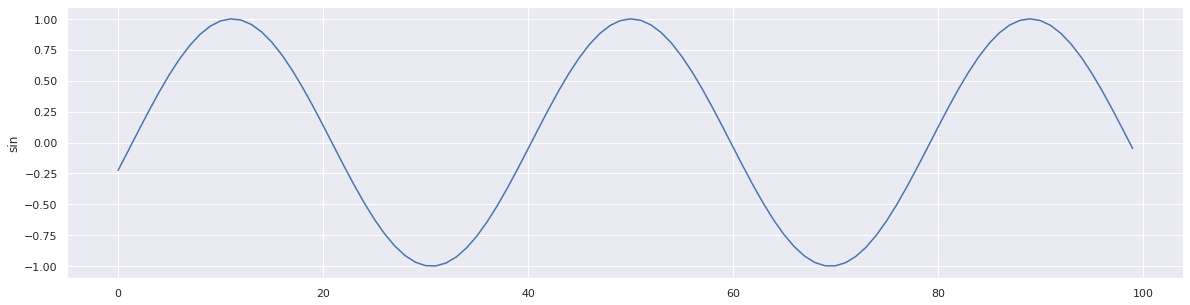

In [24]:
sns.lineplot(data=df['sin'][:100])

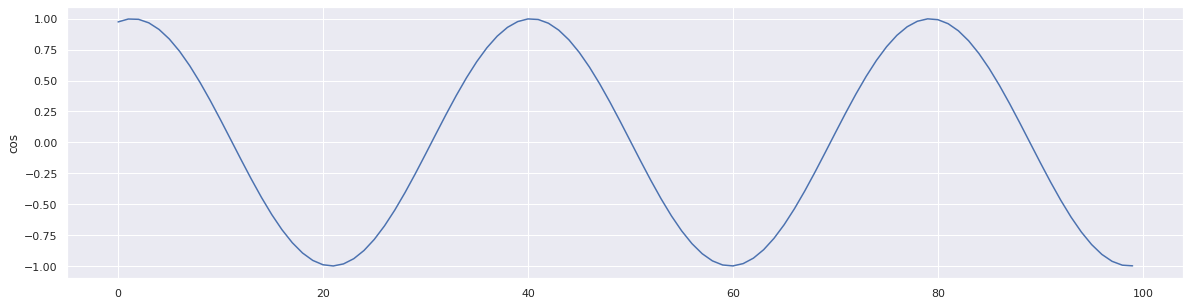

In [25]:
sns.lineplot(data=df['cos'][:100])

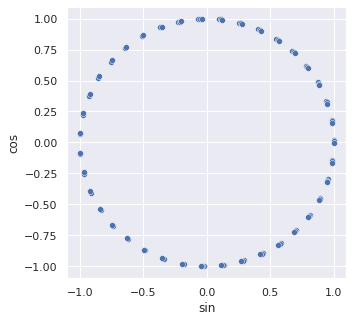

In [26]:
sns.set(rc={'figure.figsize':(5,5)})
sns.scatterplot(data=df[['sin', 'cos']][:100], x="sin", y="cos")

In [27]:
# convert to stantand latitude & longitude
df['lat'] = df['Latitude'].apply(lambda coord: float(coord.replace('N', '')) if 'N' in coord else -float(coord.replace('S', '')))
df['lng'] = df['Longitude'].apply(lambda coord: float(coord.replace('E', '')) if 'E' in coord else -float(coord.replace('W', '')))

# transform to UTM form
myProj = Proj("+proj=utm +zone=23K, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
df['UTMx'], df['UTMy'] = myProj(df['lng'].values, df['lat'].values)

# transform to Web Mercator EPSG:3857
df['EPSG_3857'] = list(zip(df.lat,df.lng))
TRAN_4326_TO_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857")
df['EPSG_3857'] = df['EPSG_3857'].apply(lambda i: TRAN_4326_TO_3857.transform(i[0], i[1]))
df['lat_3857'], df['lng_3857'] = zip(*list(df['EPSG_3857']))

# obtain adress
# get adress/postcode/name info via GeoPy ****

# transform to polygones/points
# use GDAL osgeo package

In [28]:
# translate all countries to english
translator = google_translator() 
countries_en = [translator.translate(c)[:-1] for c in np.unique(df['Country'])]
countries_en = dict(ChainMap(*[{c1:c2} for c1,c2 in zip(np.unique(df['Country']),countries_en) if c1!=c2]))
df['country_en'] = df['Country'].replace(countries_en)

# convert to numeric column (labelencoding)
df['country_code'] =  df['country_en'].astype('category').cat.codes

# bigger texts can be transformed in many ways
# use NLP for your purposes

In [29]:
df

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,date,AverageTemperature_int,AverageTemperature_rounded,AverageTemperature_minmax,AverageTemperature_standard,AverageTemperature_kmeans,AverageTemperature_kbins,AverageTemperature_log,AverageTemperature_0,AverageTemperature_1,AverageTemperature_2,AverageTemperature_3,AverageTemperature_4,AverageTemperature_5,AverageTemperature_6,AverageTemperature_7,AverageTemperature_8,AverageTemperature_9,AverageTemperature_hot_cold,month_of_year,week_of_year,day_of_year,season,day_of_week,weekend,holiday,time,hour,part_of_day,minute,sin,cos,lat,lng,UTMx,UTMy,EPSG_3857,lat_3857,lng_3857,country_en,country_code
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-01-01,26,26.7,0.822012,0.864207,8,8.0,3.979252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot,1,1,1,winter,Monday,0,True,23:08:04,23,Night,1388,-0.224951,0.974370,5.63,-3.23,5.592044e+06,8.344627e+05,"(-359561.9552622736, 627739.7302061038)",-3.595620e+05,6.277397e+05,Ivory Coast,21
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-02-01,27,27.4,0.833233,0.938672,8,8.0,3.992810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot,2,5,32,spring,Thursday,3,False,23:45:04,23,Night,1425,-0.065403,0.997859,5.63,-3.23,5.592044e+06,8.344627e+05,"(-359561.9552622736, 627739.7302061038)",-3.595620e+05,6.277397e+05,Ivory Coast,21
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-03-01,28,28.1,0.843486,1.006709,8,8.0,4.005040,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot,3,9,60,spring,Thursday,3,False,00:22:04,0,Late Night,22,0.095846,0.995396,5.63,-3.23,5.592044e+06,8.344627e+05,"(-359561.9552622736, 627739.7302061038)",-3.595620e+05,6.277397e+05,Ivory Coast,21
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-04-01,26,26.1,0.813343,0.806676,8,8.0,3.968649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot,4,13,91,spring,Sunday,6,False,00:59:04,0,Late Night,59,0.254602,0.967046,5.63,-3.23,5.592044e+06,8.344627e+05,"(-359561.9552622736, 627739.7302061038)",-3.595620e+05,6.277397e+05,Ivory Coast,21
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W,1849-05-01,25,25.4,0.802383,0.733946,1,8.0,3.955082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,hot,5,18,121,spring,Tuesday,1,False,01:36:04,1,Late Night,96,0.406737,0.913545,5.63,-3.23,5.592044e+06,8.344627e+05,"(-359561.9552622736, 627739.7302061038)",-3.595620e+05,6.277397e+05,Ivory Coast,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239172,2013-05-01,18.979,0.807,Xian,China,34.56N,108.97E,2013-05-01,18,19.0,0.703266,0.076213,3,7.0,3.823236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot,5,18,121,spring,Wednesday,2,False,08:32:04,8,Morning,512,0.788011,-0.615661,34.56,108.97,2.915961e+06,1.584701e+07,"(12130484.91174302, 4104246.5068497644)",1.213048e+07,4.104247e+06,China,8
239173,2013-06-01,23.522,0.647,Xian,China,34.56N,108.97E,2013-06-01,23,23.5,0.773100,0.539625,1,7.0,3.917906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot,6,22,152,summer,Saturday,5,False,09:09:04,9,Morning,549,0.678801,-0.734323,34.56,108.97,2.915961e+06,1.584701e+07,"(12130484.91174302, 4104246.5068497644)",1.213048e+07,4.104247e+06,China,8
239174,2013-07-01,25.251,1.042,Xian,China,34.56N,108.97E,2013-07-01,25,25.3,0.799677,0.715993,1,7.0,3.951705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot,7,27,182,summer,Monday,0,False,09:46:04,9,Morning,586,0.551937,-0.833886,34.56,108.97,2.915961e+06,1.584701e+07,"(12130484.91174302, 4104246.5068497644)",1.213048e+07,4.104247e+06,China,8
239175,2013-08-01,24.528,0.840,Xian,China,34.56N,108.97E,2013-08-01,24,24.5,0.788564,0.642243,1,7.0,3.937710,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,hot,8,31,213,summer,Thursday,3,False,10:23:04,10,Morning,623,0.410719,-0.911762,34.56,108.97,2.915961e+06,1.584701e+07,"(12130484.91174302, 4104246.5068497644)",1.213048e+07,4.104247e+06,Chin